In [1]:
import os

if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('../../../AutexysHost/source')

from utilities import DataLoggerUtility as dlu
from utilities import DataPlotterUtility as dpu
from utilities import FET_Modeling as fet_model
from procedures import Device_History as DH
from procedures import AFM_Control as afm_ctrl
import launcher
import defaults

from matplotlib import pyplot as plt
import numpy as np

import scipy.optimize as sci_opt

saveFolder = '../../../Publications/2018-04-30 Bias Stress ACS/Plots'

# %config InlineBackend.figure_format = 'svg'

In [12]:
def calculateBaseline(xs, ys, direction=0, iterations=5):
    baseline = np.copy(ys)
    
    for i in range(iterations):
        fit = np.polyfit(np.ravel(xs), np.ravel(baseline), 1)
        fitFunc = np.poly1d(fit)
        fitVals = fitFunc(xs)
        
        baseline = np.minimum(baseline, fitVals)
    
    return baseline

def calculateBaselineFromTraces(traces):
    times = traces['time']
    values = traces['Id']
    
    segments = min(len(times), len(values))
    
    for i in range(segments):
        imin = max(i-1, 0)
        imax = min(i+1, segments)
        
        segTimes = times[imin:imax]
        segValues = times[imin:imax]
        
        segBaseline = calculateBaseline(segTimes, segValues, direction=-1)
        
        

def subtractBaselineFromTraces(traces):
    pass

def rowDiff(row1, row2, offset, compareLength):
    if offset >= 0:
        return row1[offset:offset+compareLength] - row2[0:compareLength]
    else:
        return row1[0:compareLength] - row2[abs(offset):abs(offset)+compareLength]

def rowDiffSquaredError(row1, row2, offset, compareLength):
    return np.sum(np.array(rowDiff(row1, row2, offset, compareLength))**2)

def rowOffsetsAndErrors(row1, row2, maxOffsetPercent):
    maxLength = max(len(row1), len(row2))
    minLength = min(len(row1), len(row2))
    
    maxOffset = int(maxOffsetPercent/100*minLength)
    compareLength = minLength - maxOffset
    
    offsets = list(range(-maxOffset, maxOffset+1))
    errors = [rowDiffSquaredError(row1, row2, offset, compareLength) for offset in offsets]
    
    return np.array(offsets), np.array(errors)

def bestRowXOffsetAndError(row1, row2, maxOffsetPercent):
    offsets, errors = rowOffsetsAndErrors(row1, row2, maxOffsetPercent)
    
    offsets = np.array(offsets)
    errors = np.array(errors)
    
    # Only accept the offset if it reduces the error to less than half of what it was with no offset
    if min(errors)/errors[np.argmin(offsets)] < 0.5:
        offset = offsets[np.argmin(errors)]
    else:
        offset = 0.0
    
    error = errors[offsets == offset][0]
    
    return offset, error

def bestXOffsetsAndErrors(m1, m2, maxOffsetPercent):
    # get offsets of m2 by comparisson to m1
    minRows = min(len(m1), len(m2))
    offsetsAndErrors = [bestRowXOffsetAndError(m1[row], m2[row], 5) for row in range(minRows)]
    offsetsAndErrors = np.array(offsetsAndErrors)
    
    offsets = offsetsAndErrors[:,0]
    errors = offsetsAndErrors[:,1]
    
    return offsets, errors

def applyXOffsetsToMatrix(m, xoffsets, width=0):
    xoffsetsAbsolute = np.array(xoffsets)
    if min(xoffsets) < 0:
        xoffsetsAbsolute -= min(xoffsets)
    
    rows = m.shape[0]
    cols = m.shape[1] + int(max(xoffsetsAbsolute))
    cols = max(cols, width)
    
    mnew = np.zeros((rows, cols))*np.nan
    
    for row in range(len(xoffsetsAbsolute)):
        offset = int(xoffsetsAbsolute[row])
        mnew[row][offset:m.shape[1]+offset] = m[row]
    
    return mnew

def alignMatrixes(matrixes, masterIndex=0, sequential=True, maxOffsetPercent=5, trimX=True):
    minRows = min([m.shape[0] for m in matrixes])
    
    allOffsets = np.zeros((len(matrixes), minRows))
    
    for i in range(masterIndex + 1, len(matrixes)):
        offsets, errors = bestXOffsetsAndErrors(matrixes[i-1], matrixes[i], maxOffsetPercent)
        allOffsets[i] = allOffsets[i-1] + offsets[0:minRows]
    
    for i in range(masterIndex - 1, 0 - 1, -1):
        offsets, errors = bestXOffsetsAndErrors(matrixes[i+1], matrixes[i], maxOffsetPercent)
        allOffsets[i] = allOffsets[i+1] + offsets[0:minRows]
    
    allOffsets -= np.min(allOffsets)
    maxWidths = [matrixes[i].shape[1] + np.max(allOffsets[i]) for i in range(len(matrixes))]
    minWidths = [matrixes[i].shape[1] + np.min(allOffsets[i]) for i in range(len(matrixes))]
    maxCols = int(max(maxWidths))
    
    startTrimX = int(np.max(allOffsets))
    endTrimX = int(np.min(minWidths))
    
    alignedMatrices = []
    for i in range(len(matrixes)):
        m = applyXOffsetsToMatrix(matrixes[i], allOffsets[i], width=maxCols)
        
        if trimX:
            m = m[:,startTrimX:endTrimX]
        
        alignedMatrices.append(m[0:minRows])
    
    return alignedMatrices

def makeDataCube(matrices):
    widths =  [m.shape[0] for m in matrices]
    heights = [m.shape[1] for m in matrices]
    
    rows = min(widths)
    cols = min(heights)
    
    dataCube = np.zeros((len(matrices), rows, cols))
    
    for i in range(len(matrices)):
        dataCube[i] = matrices[i][0:rows,0:cols]
    
    return dataCube

def separateDeviceHistoryByScans(dh):
    result = []
    
    for scan in range(dh[0]['runConfigs'][dh[0]['runType']]['scans']):
        dhs = [e for e in dh if e['Results']['scan'] == scan]
        if len(dhs) > 0:
            result.append(dhs)
    
    return result

def getFrameStandardDeviations(dc):
    return np.std(dc, axis=(1,2))

def getFrameIndexOfLargestSpread(dc):
    stds = getFrameStandardDeviations(dc)
    return np.argmax(stds)

def getPercentileRangeMask(dc, pMin, pMax, frameNumber=None):
    if frameNumber is None:
        frameNumber = getFrameIndexOfLargestSpread(dc)
    
    frame = dc[frameNumber]
    
    # Allow for accidental swap of percentile bounds
    pMin, pMax = min([pMin, pMax]), max([pMin, pMax])
    
    indexes = (frame >= np.nanpercentile(frame, pMin)) & (frame <= np.nanpercentile(frame, pMax))
    
    return indexes

def getMasksForPercentileGroups(dc, percentileBreaks=[0,20,40,60,80,100]):
    pB = percentileBreaks
    percentilePairs = [[pB[i],pB[i+1]] for i in range(len(pB)-1)]
    
    masks = [getPercentileRangeMask(dc, pp[0], pp[1]) for pp in percentilePairs]
    
    return masks, percentilePairs

def trackedPercentileRangeMedians():
    pass

# MoS2 Screening Length JM4C 27-30

In [2]:
experimentNumbers = list(range(75,87+1))

heightSeq = []

for experimentNumber in experimentNumbers:
    e = {}
    
    dh = dlu.loadSpecificDeviceHistory('../../AutexysData/jay/MoS2FET/JM4/C/27-30/', 'AFMControl.json', minExperiment=experimentNumber, maxExperiment=experimentNumber)
    
    traces = afm_ctrl.extractTraces(dh)
    traceNumber = 0
    
    Vx_vals = traces['Vx'][traceNumber]
    Vy_vals = traces['Vy'][traceNumber]
    Id_vals = traces['Id'][traceNumber]
    
    sgm_matrix, sgmWidth, sgmHeight = afm_ctrl.getRasteredMatrix(Vx_vals, Vy_vals, Id_vals)
    sgm_matrix = afm_ctrl.interpolate_nans(sgm_matrix)
    
    e['sgm_matrix'] = sgm_matrix*1e9
    e['sgmWidth'] = sgmWidth
    e['sgmHeight'] = sgmHeight
    e['runParams'] = dh[0]['runConfigs'][dh[0]['runType']]
    
    heightSeq.append(e)


ValueError: array of sample points is empty

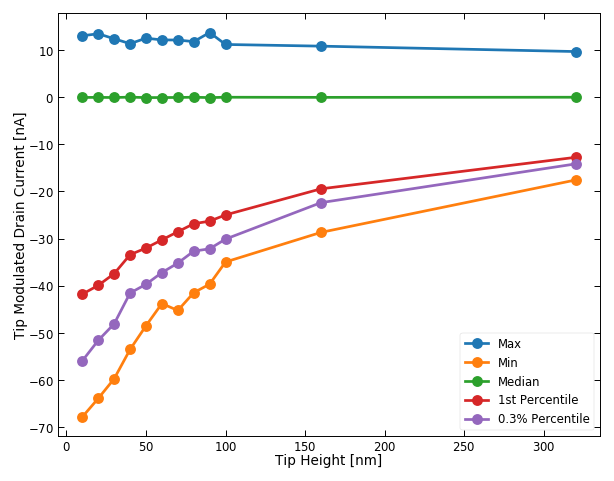

In [3]:
plt.figure(figsize=(5,4), dpi=140)

heights = [e['runParams']['NapHeight[nm]'] for e in heightSeq]
maxIds = [np.max(e['sgm_matrix']) for e in heightSeq]
minIds = [np.min(e['sgm_matrix']) for e in heightSeq]
medianIds = [np.median(e['sgm_matrix']) for e in heightSeq]
percentile1Ids = [np.percentile(e['sgm_matrix'], 1) for e in heightSeq]
percentile03Ids = [np.percentile(e['sgm_matrix'], 0.3) for e in heightSeq]

plt.plot(heights, maxIds, 'o-', label='Max')
plt.plot(heights, minIds, 'o-', label='Min')
plt.plot(heights, medianIds, 'o-', label='Median')
plt.plot(heights, percentile1Ids, 'o-', label='1st Percentile')
plt.plot(heights, percentile03Ids, 'o-', label='0.3% Percentile')

plt.xlabel('Tip Height [nm]')
plt.ylabel('Tip Modulated Drain Current [nA]')
plt.legend()
plt.show()

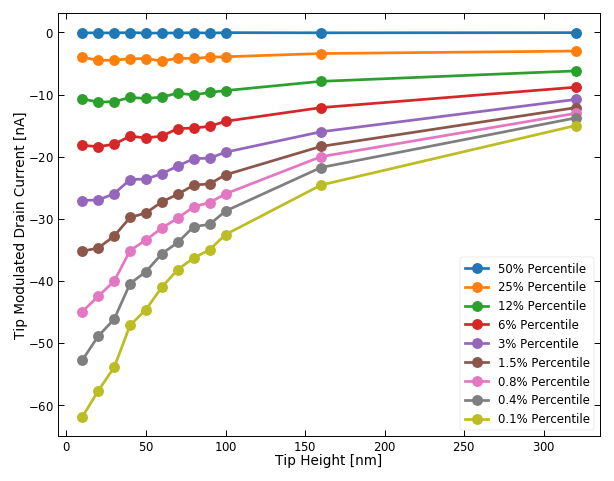

In [59]:
plt.figure(figsize=(5,4), dpi=140)

heights = [e['runParams']['NapHeight[nm]'] for e in heightSeq]

for percentile in reversed([0.1, 0.4, 0.8, 1.5, 3, 6, 12, 25, 50]):
    percentileIds = [np.percentile(e['sgm_matrix'], percentile) for e in heightSeq]
    plt.plot(heights, percentileIds, 'o-', label='{}% Percentile'.format(percentile))

plt.xlabel('Tip Height [nm]')
plt.ylabel('Tip Modulated Drain Current [nA]')
plt.legend()
plt.show()

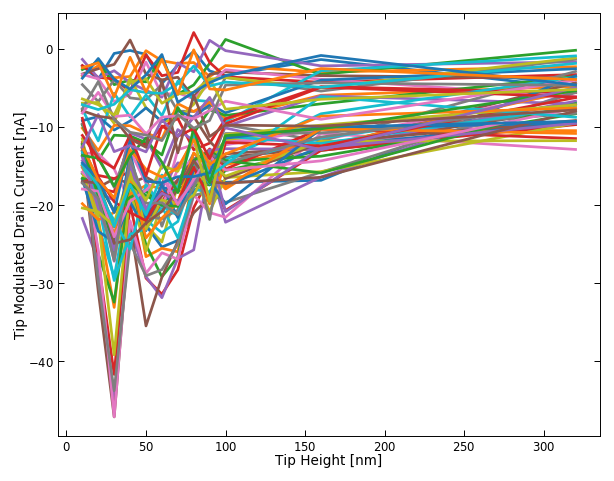

In [70]:
plt.figure(figsize=(5,4), dpi=140)

minRows = min([e['sgm_matrix'].shape[0] for e in heightSeq])
minCols = min([e['sgm_matrix'].shape[1] for e in heightSeq])

for row in range(minRows):
    pointIds = [e['sgm_matrix'][row][256] for e in heightSeq]
    plt.plot(heights, pointIds)

plt.xlabel('Tip Height [nm]')
plt.ylabel('Tip Modulated Drain Current [nA]')
plt.show()

In [71]:
minRows = min([e['sgm_matrix'].shape[0] for e in heightSeq])
minCols = min([e['sgm_matrix'].shape[1] for e in heightSeq])

maxRows = max([e['sgm_matrix'].shape[0] for e in heightSeq])
maxCols = max([e['sgm_matrix'].shape[1] for e in heightSeq])

print(minRows, maxRows, minCols, maxCols)

62 64 516 524


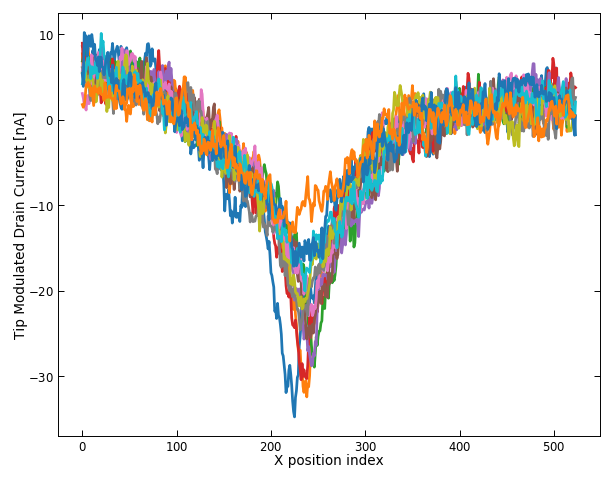

In [72]:
plt.figure(figsize=(5,4), dpi=140)

for e in heightSeq:
    pointIds = e['sgm_matrix'][32]
    plt.plot(pointIds)

plt.xlabel('X position index')
plt.ylabel('Tip Modulated Drain Current [nA]')
plt.show()

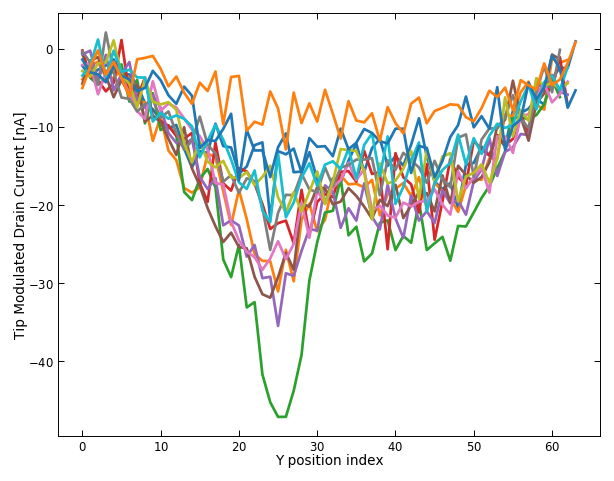

In [75]:
plt.figure(figsize=(5,4), dpi=140)

for e in heightSeq:
    pointIds = e['sgm_matrix'][:,256]
    plt.plot(pointIds)

plt.xlabel('Y position index')
plt.ylabel('Tip Modulated Drain Current [nA]')
plt.show()

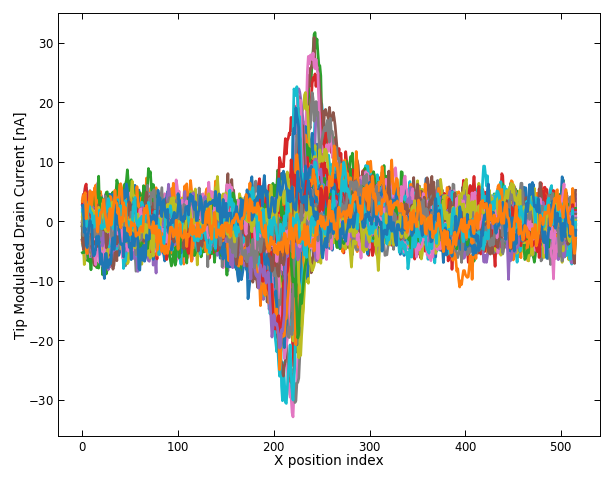

In [92]:
plt.figure(figsize=(5,4), dpi=140)

for row in range(minRows):
    offset = 0
    pointIds = heightSeq[0]['sgm_matrix'][row][0:minCols-offset] - heightSeq[1]['sgm_matrix'][row][offset:minCols]
    plt.plot(pointIds)

plt.xlabel('X position index')
plt.ylabel('Tip Modulated Drain Current [nA]')
plt.show()

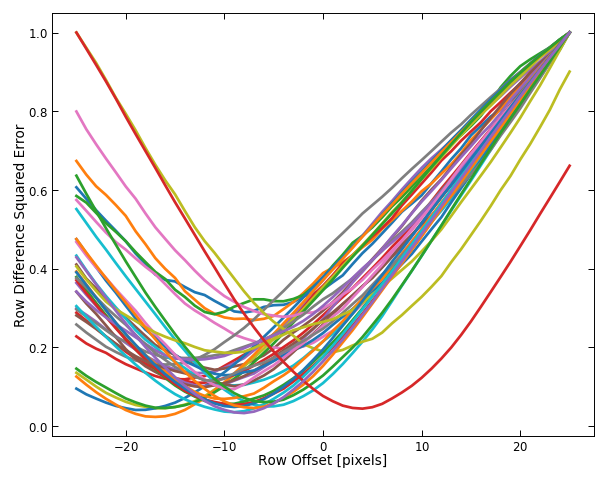

In [163]:
plt.figure(figsize=(5,4), dpi=140)

for row in range(15,50):
    offsets, errors = rowOffsetsAndErrors(heightSeq[0]['sgm_matrix'][row], heightSeq[1]['sgm_matrix'][row], 5)
    plt.plot(offsets, errors/max(errors))

plt.xlabel('Row Offset [pixels]')
plt.ylabel('Row Difference Squared Error')
plt.show()

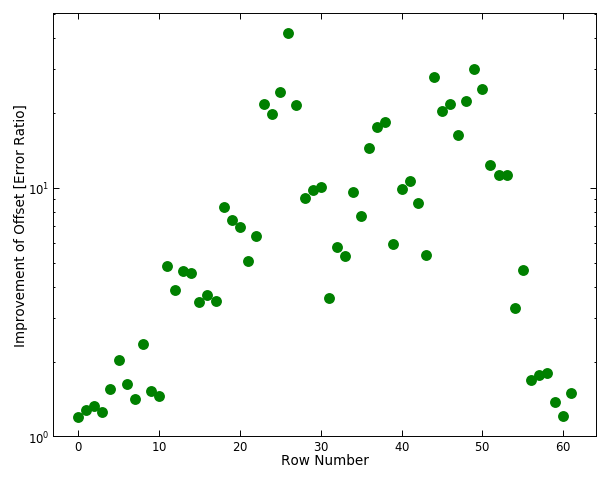

In [164]:
plt.figure(figsize=(5,4), dpi=140)

for row in range(minRows):
    offsets, errors = rowOffsetsAndErrors(heightSeq[0]['sgm_matrix'][row], heightSeq[1]['sgm_matrix'][row], 5)
    plt.semilogy(row, max(errors)/min(errors), 'go')

plt.xlabel('Row Number')
plt.ylabel('Improvement of Offset [Error Ratio]')
plt.show()

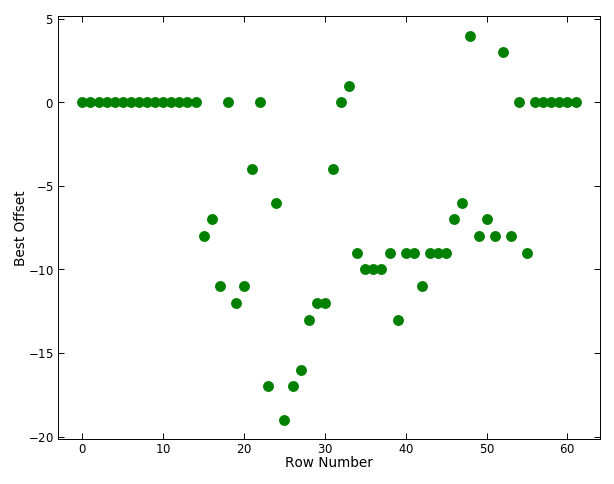

In [184]:
plt.figure(figsize=(5,4), dpi=140)

for row in range(minRows):
    offset, error = bestRowXOffsetAndError(heightSeq[0]['sgm_matrix'][row], heightSeq[1]['sgm_matrix'][row], 5)
    plt.plot(row, offset, 'go')

plt.xlabel('Row Number')
plt.ylabel('Best Offset')
plt.show()

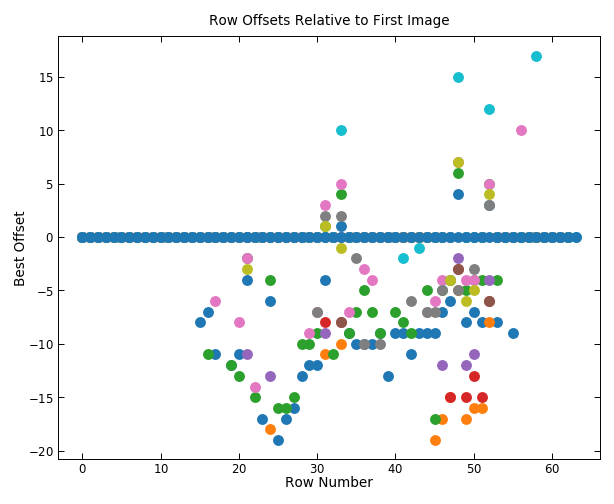

In [201]:
plt.figure(figsize=(5,4), dpi=140)

for i in range(1,len(heightSeq)):
    offsets, errors = bestXOffsetsAndErrors(heightSeq[0]['sgm_matrix'], heightSeq[i]['sgm_matrix'], 5)
    plt.plot(offsets, 'o')

plt.title('Row Offsets Relative to First Image')
plt.xlabel('Row Number')
plt.ylabel('Best Offset')
plt.show()

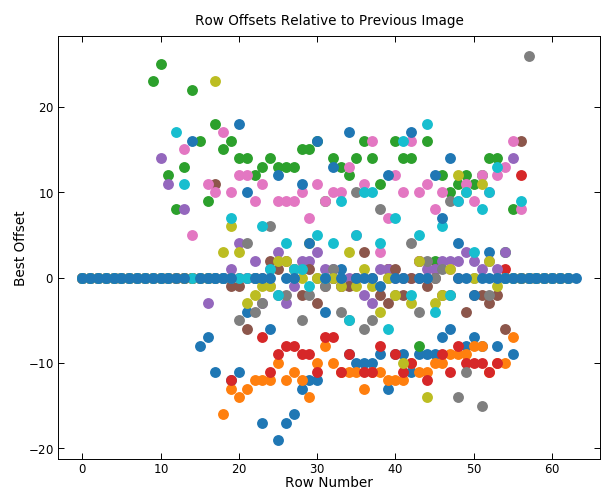

In [202]:
plt.figure(figsize=(5,4), dpi=140)

for i in range(1,len(heightSeq)):
    offsets, errors = bestXOffsetsAndErrors(heightSeq[i-1]['sgm_matrix'], heightSeq[i]['sgm_matrix'], 5)
    plt.plot(offsets, 'o')

plt.title('Row Offsets Relative to Previous Image')
plt.xlabel('Row Number')
plt.ylabel('Best Offset')
plt.show()

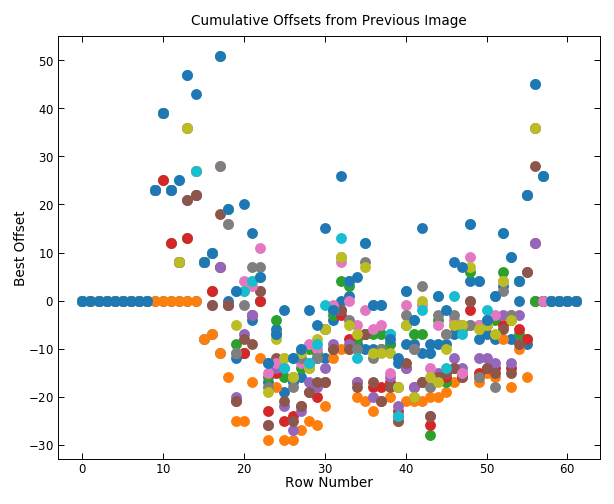

In [203]:
plt.figure(figsize=(5,4), dpi=140)

cumulativeOffsets = np.zeros(minRows)

for i in range(1,len(heightSeq)):
    offsets, errors = bestXOffsetsAndErrors(heightSeq[i-1]['sgm_matrix'], heightSeq[i]['sgm_matrix'], 5)
    cumulativeOffsets += offsets[0:minRows]
    plt.plot(cumulativeOffsets, 'o')

plt.title('Cumulative Offsets from Previous Image')
plt.xlabel('Row Number')
plt.ylabel('Best Offset')
plt.show()

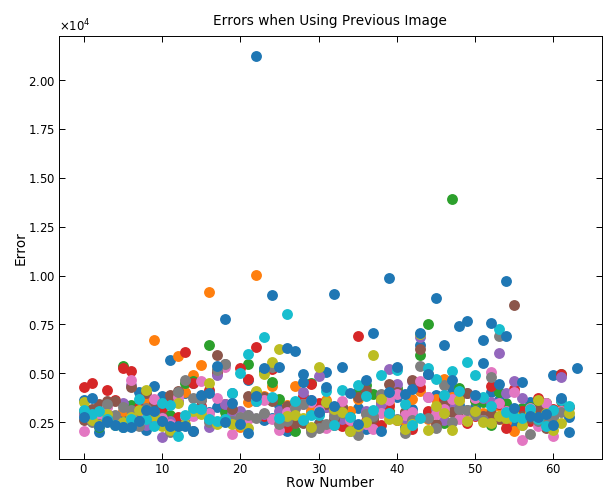

In [205]:
plt.figure(figsize=(5,4), dpi=140)

cumulativeOffsets = np.zeros(minRows)

for i in range(1,len(heightSeq)):
    offsets, errors = bestXOffsetsAndErrors(heightSeq[i-1]['sgm_matrix'], heightSeq[i]['sgm_matrix'], 5)
    plt.plot(errors, 'o')

plt.title('Errors when Using Previous Image')
plt.xlabel('Row Number')
plt.ylabel('Error')
plt.show()

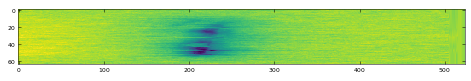

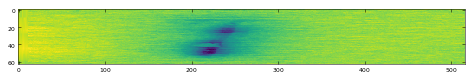

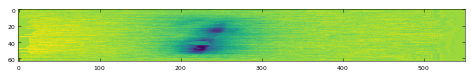

In [228]:
offsets, errors = bestXOffsetsAndErrors(heightSeq[1]['sgm_matrix'], heightSeq[0]['sgm_matrix'], 5)
m = applyXOffsetsToMatrix(heightSeq[0]['sgm_matrix'], offsets)

plt.imshow(heightSeq[0]['sgm_matrix'])
plt.show()

plt.imshow(heightSeq[1]['sgm_matrix'])
plt.show()

plt.imshow(m)
plt.show()

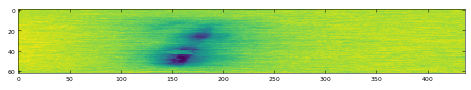

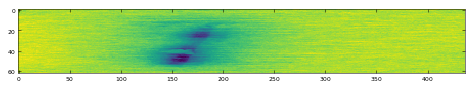

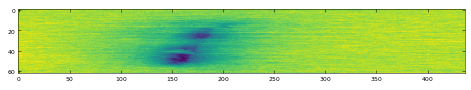

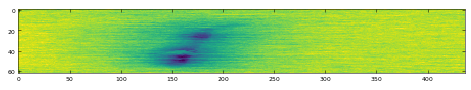

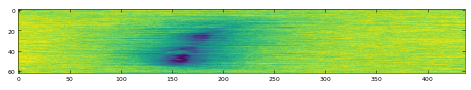

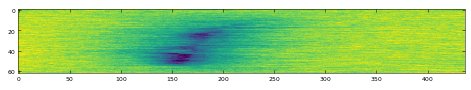

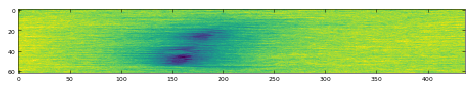

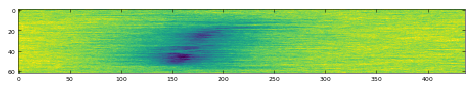

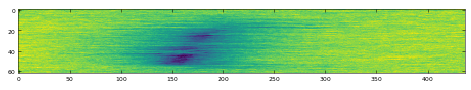

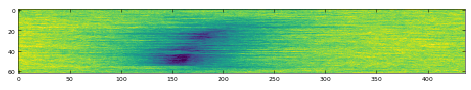

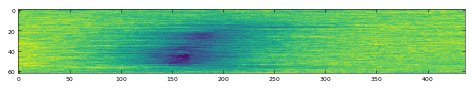

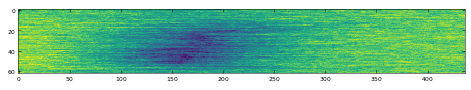

In [277]:
matrices = [e['sgm_matrix'] for e in heightSeq]

alignedMatrices = alignMatrixes(matrices, masterIndex=1)
heightSeqCube = makeDataCube(alignedMatrices)

for am in alignedMatrices:
    plt.imshow(am)
    plt.show()

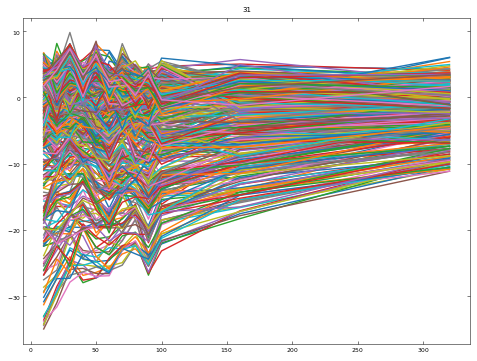

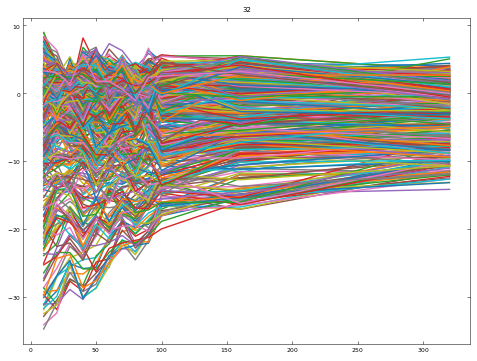

In [400]:
matrices = [e['sgm_matrix'] for e in heightSeq]

alignedMatrices = alignMatrixes(matrices, masterIndex=1)
heightSeqCube = makeDataCube(alignedMatrices)

for r in range(31,33):
    for c in range(heightSeqCube.shape[2]):
        plt.plot(heights, heightSeqCube[:,r,c])
    
    plt.title(r)
    plt.show()

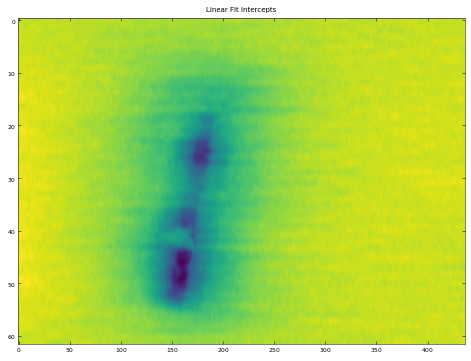

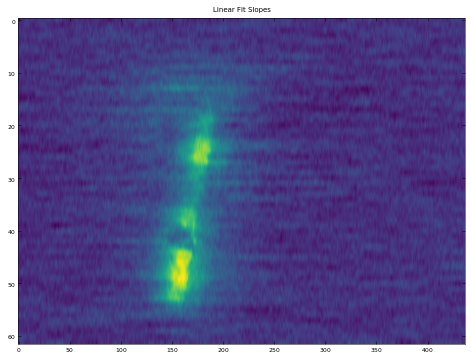

In [290]:
linearFitIntercepts = np.zeros(heightSeqCube[0].shape)
linearFitSlopes = np.zeros(heightSeqCube[0].shape)

for r in range(heightSeqCube.shape[1]):
    for c in range(heightSeqCube.shape[2]):
        ps = np.polyfit(heights, heightSeqCube[:,r,c], 1)
        linearFitSlopes[r,c] = ps[0]
        linearFitIntercepts[r,c] = ps[1]

plt.title('Linear Fit Intercepts')
plt.imshow(linearFitIntercepts, aspect='auto', interpolation='spline36')
plt.show()

plt.title('Linear Fit Slopes')
plt.imshow(linearFitSlopes, aspect='auto', interpolation='spline36')
plt.show()

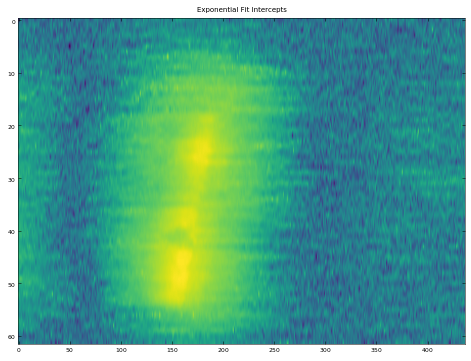

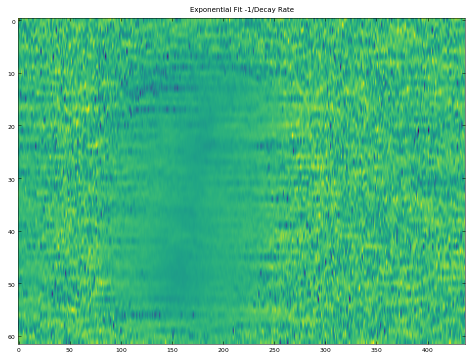

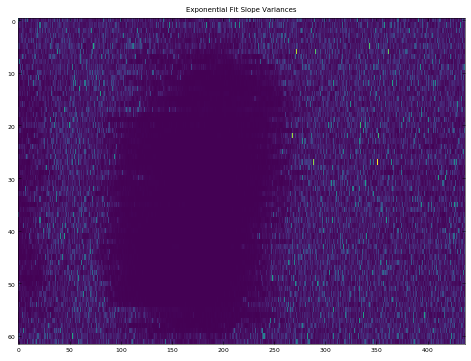

In [390]:
linearFitIntercepts = np.zeros(heightSeqCube[0].shape)
linearFitSlopes = np.zeros(heightSeqCube[0].shape)
linearFitSlopeVariances = np.zeros(heightSeqCube[0].shape)

for r in range(heightSeqCube.shape[1]):
    for c in range(heightSeqCube.shape[2]):
        ps, V = np.polyfit(heights, np.log(np.abs(heightSeqCube[:,r,c])), 1, cov=True)
        linearFitSlopes[r,c] = ps[0]
        linearFitIntercepts[r,c] = ps[1]
        linearFitSlopeVariances[r,c] = V[0][0]

plt.title('Exponential Fit Intercepts')
plt.imshow(linearFitIntercepts, aspect='auto', interpolation='spline36')
plt.show()

# linearFitSlopes = -1/linearFitSlopes
# linearFitSlopes[linearFitSlopeVariances > np.percentile(linearFitSlopeVariances, 20)] = 0
# linearFitSlopes[linearFitSlopes > np.percentile(linearFitSlopes, 50)] = np.mean(linearFitSlopes)

plt.title('Exponential Fit -1/Decay Rate')
plt.imshow(linearFitSlopes, aspect='auto', interpolation='spline36')
plt.show()

# linearFitSlopeVariances[linearFitSlopeVariances > np.percentile(linearFitSlopeVariances, 20)] = np.nan

plt.title('Exponential Fit Slope Variances')
plt.imshow(linearFitSlopeVariances, aspect='auto')
plt.show()

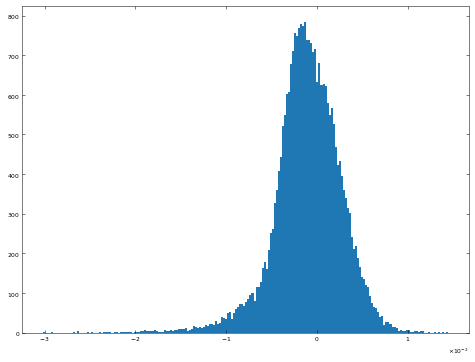

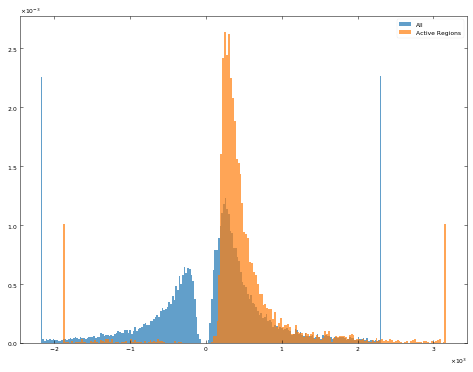

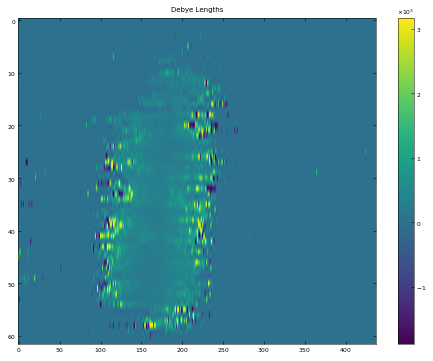

In [394]:
debyeLengths = -1/linearFitSlopes
debyeLengths[linearFitSlopeVariances > np.percentile(linearFitSlopeVariances, 20)] = 0
debyeLengths = np.clip(debyeLengths, np.percentile(debyeLengths, 0.5), np.percentile(debyeLengths, 99.5))

debyeLengths2 = -1/linearFitSlopes
# debyeLengths2[linearFitSlopeVariances > np.percentile(linearFitSlopeVariances, 40)] = 0
debyeLengths2 = np.clip(debyeLengths2, np.percentile(debyeLengths2, 5), np.percentile(debyeLengths2, 95))

plt.hist(linearFitSlopes.flatten(), bins=200)
plt.show()

plt.hist(debyeLengths2[np.nonzero(debyeLengths2)].flatten(), bins=200, density=True, alpha=0.7, label='All')
plt.hist(debyeLengths[np.nonzero(debyeLengths)].flatten(), bins=200, density=True, alpha=0.7, label='Active Regions')
plt.legend()
plt.show()

plt.title('Debye Lengths')
plt.imshow(debyeLengths, aspect='auto', interpolation='spline36')
plt.colorbar()
plt.show()

In [395]:
np.median(np.nonzero(debyeLengths))

58.0

In [396]:
np.mean(np.nonzero(debyeLengths))

103.19874515593283

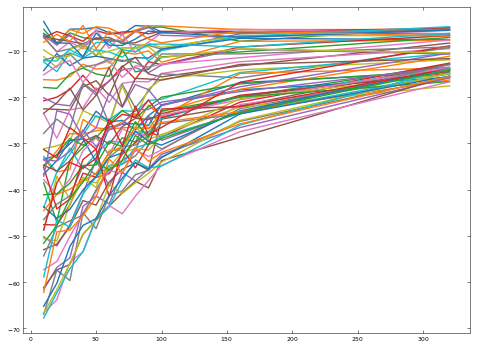

In [405]:
rowResponses = []

for r in range(heightSeqCube.shape[1]):
    highs = [np.min(e[r,:]) for e in heightSeqCube]
    rowResponses.append(highs)
    plt.plot(heights, highs)

plt.show()

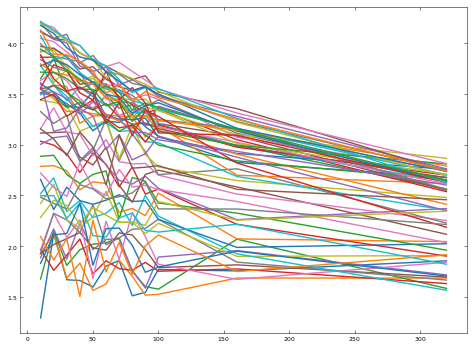

In [406]:
for resp in rowResponses:
    plt.plot(heights, np.log(np.abs(resp)))

plt.show()

# 3 Fin SGM Analysis F1E27N_10000_S4

## Debye Length Extraction

In [15]:
experimentNumbers = list(range(7,15+1))

heightSeq = []

for experimentNumber in experimentNumbers:
    try:
        e = {}

        dh = dlu.loadSpecificDeviceHistory('../../AutexysData/steven/SGM1/F1/E/E27N_10000_S4/', 'AFMControl.json', minExperiment=experimentNumber, maxExperiment=experimentNumber)

        traces = afm_ctrl.extractTraces(dh)
        traceNumber = 0

        Vx_vals = traces['Vx'][traceNumber]
        Vy_vals = traces['Vy'][traceNumber]
        Id_vals = traces['Id'][traceNumber]

        sgm_matrix, sgmWidth, sgmHeight = afm_ctrl.getRasteredMatrix(Vx_vals, Vy_vals, Id_vals)
        sgm_matrix = afm_ctrl.interpolate_nans(sgm_matrix)

        e['sgm_matrix'] = sgm_matrix*1e9
        e['sgmWidth'] = sgmWidth
        e['sgmHeight'] = sgmHeight
        e['runParams'] = dh[0]['runConfigs'][dh[0]['runType']]

        heightSeq.append(e)
    except Exception as e:
        print('Error ', e)

Error  max() arg is an empty sequence


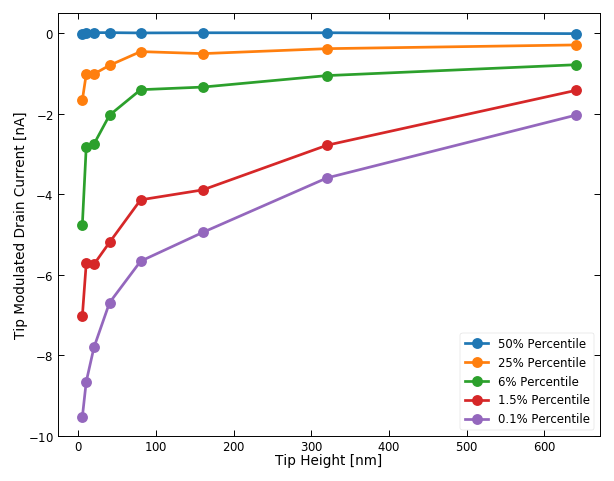

In [10]:
plt.figure(figsize=(5,4), dpi=140)

heights = [e['runParams']['NapHeight[nm]'] for e in heightSeq]

for percentile in reversed([0.1, 1.5, 6, 25, 50]):
    percentileIds = [np.percentile(e['sgm_matrix'], percentile) for e in heightSeq]
    plt.plot(heights, percentileIds, 'o-', label='{}% Percentile'.format(percentile))

plt.xlabel('Tip Height [nm]')
plt.ylabel('Tip Modulated Drain Current [nA]')
plt.legend()
plt.show()

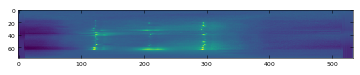

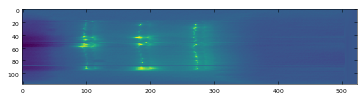

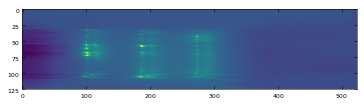

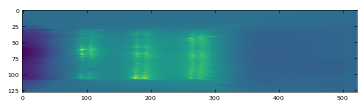

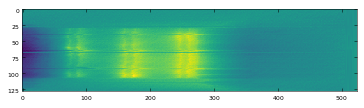

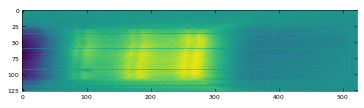

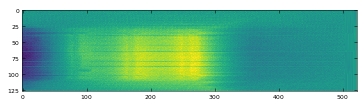

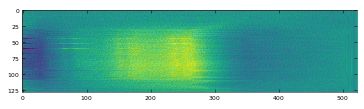

In [12]:
for e in heightSeq:
    plt.imshow(e['sgm_matrix'])
    plt.show()

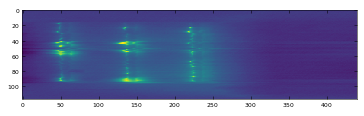

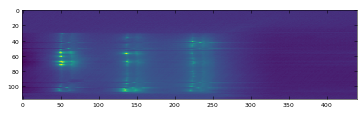

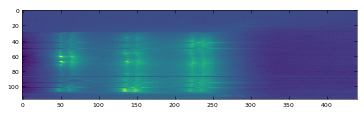

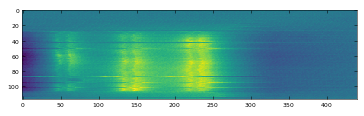

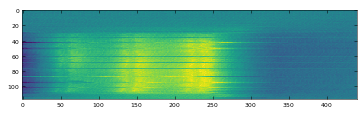

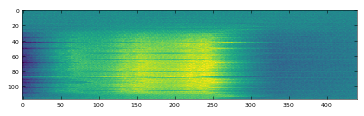

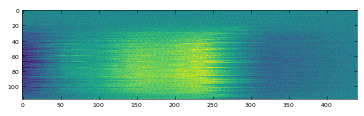

In [16]:
# First image is of a different size

matrices = [e['sgm_matrix'] for e in heightSeq[1:]]

alignedMatrices = alignMatrixes(matrices, masterIndex=1)
heightSeqCube = makeDataCube(alignedMatrices)

for am in alignedMatrices:
    plt.imshow(am)
    plt.show()

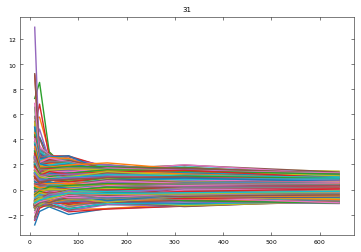

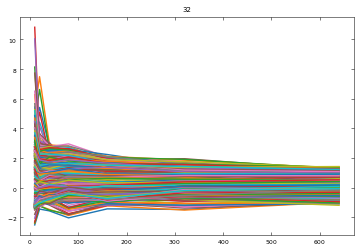

In [18]:
for r in range(31,33):
    for c in range(heightSeqCube.shape[2]):
        plt.plot(heights[1:], heightSeqCube[:,r,c])
    
    plt.title(r)
    plt.show()

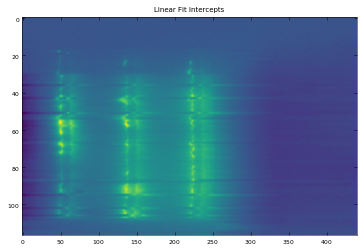

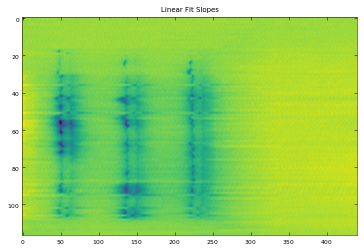

In [20]:
linearFitIntercepts = np.zeros(heightSeqCube[0].shape)
linearFitSlopes = np.zeros(heightSeqCube[0].shape)

for r in range(heightSeqCube.shape[1]):
    for c in range(heightSeqCube.shape[2]):
        ps = np.polyfit(heights[1:], heightSeqCube[:,r,c], 1)
        linearFitSlopes[r,c] = ps[0]
        linearFitIntercepts[r,c] = ps[1]

plt.title('Linear Fit Intercepts')
plt.imshow(linearFitIntercepts, aspect='auto', interpolation='spline36')
plt.show()

plt.title('Linear Fit Slopes')
plt.imshow(linearFitSlopes, aspect='auto', interpolation='spline36')
plt.show()

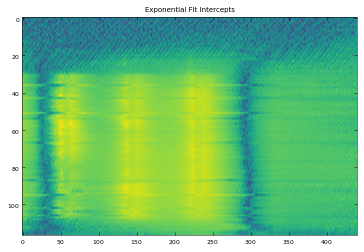

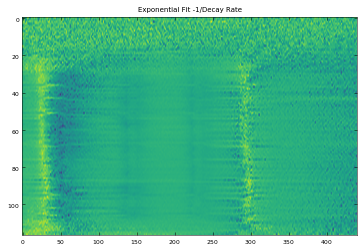

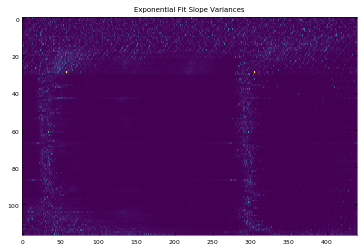

In [22]:
linearFitIntercepts = np.zeros(heightSeqCube[0].shape)
linearFitSlopes = np.zeros(heightSeqCube[0].shape)
linearFitSlopeVariances = np.zeros(heightSeqCube[0].shape)

for r in range(heightSeqCube.shape[1]):
    for c in range(heightSeqCube.shape[2]):
        ps, V = np.polyfit(heights[1:], np.log(np.abs(heightSeqCube[:,r,c])), 1, cov=True)
        linearFitSlopes[r,c] = ps[0]
        linearFitIntercepts[r,c] = ps[1]
        linearFitSlopeVariances[r,c] = V[0][0]

plt.title('Exponential Fit Intercepts')
plt.imshow(linearFitIntercepts, aspect='auto', interpolation='spline36')
plt.show()

# linearFitSlopes = -1/linearFitSlopes
# linearFitSlopes[linearFitSlopeVariances > np.percentile(linearFitSlopeVariances, 20)] = 0
# linearFitSlopes[linearFitSlopes > np.percentile(linearFitSlopes, 50)] = np.mean(linearFitSlopes)

plt.title('Exponential Fit -1/Decay Rate')
plt.imshow(linearFitSlopes, aspect='auto', interpolation='spline36')
plt.show()

# linearFitSlopeVariances[linearFitSlopeVariances > np.percentile(linearFitSlopeVariances, 20)] = np.nan

plt.title('Exponential Fit Slope Variances')
plt.imshow(linearFitSlopeVariances, aspect='auto')
plt.show()

## Time Evolution

In [124]:
dhFull = dlu.loadSpecificDeviceHistory('../../AutexysData/steven/SGM1/F1/E/E27N_10000_S4/', 'AFMControl.json', minExperiment=17, maxExperiment=17)

dhs = separateDeviceHistoryByScans(dhFull)
seq = []

for dh in dhs:
    e = {}
    
    traces = afm_ctrl.extractTraces(dh)
    traceNumber = 0
    
    Vx_vals = traces['Vx'][traceNumber]
    Vy_vals = traces['Vy'][traceNumber]
    Id_vals = traces['Id'][traceNumber]
    
    sgm_matrix, sgmWidth, sgmHeight = afm_ctrl.getRasteredMatrix(Vx_vals, Vy_vals, Id_vals)
    sgm_matrix = afm_ctrl.interpolate_nans(sgm_matrix)
    
    e['sgm_matrix'] = sgm_matrix*1e9
    e['sgmWidth'] = sgmWidth
    e['sgmHeight'] = sgmHeight
    e['runParams'] = dh[0]['runConfigs'][dh[0]['runType']]
    
    seq.append(e)


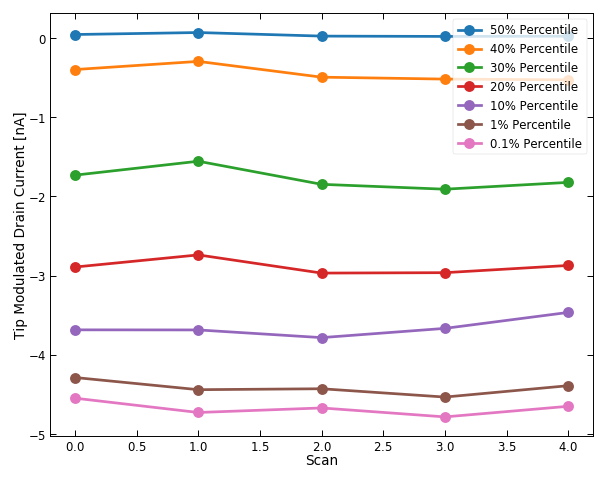

In [39]:
plt.figure(figsize=(5,4), dpi=140)

for percentile in reversed([0.1, 1, 10, 20, 30, 40, 50]):
    percentileIds = [np.percentile(e['sgm_matrix'], percentile) for e in seq]
    plt.plot(percentileIds, 'o-', label='{}% Percentile'.format(percentile))

plt.xlabel('Scan')
plt.ylabel('Tip Modulated Drain Current [nA]')
plt.legend()
plt.show()

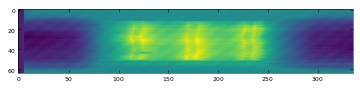

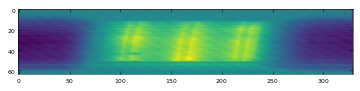

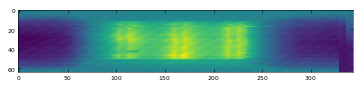

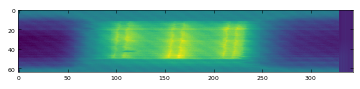

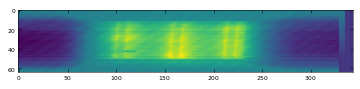

In [43]:
for e in seq:
    plt.imshow(e['sgm_matrix'])
    plt.show()

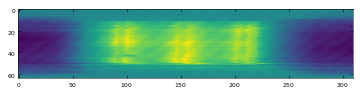

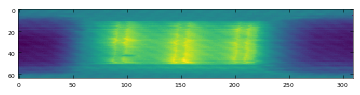

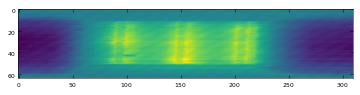

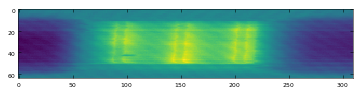

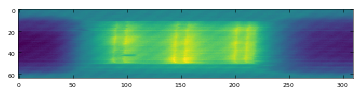

In [125]:
matrices = [e['sgm_matrix'] for e in seq]

alignedMatrices = alignMatrixes(matrices, masterIndex=4)
seqCube = makeDataCube(alignedMatrices)

for am in alignedMatrices:
    plt.imshow(am)
    plt.show()

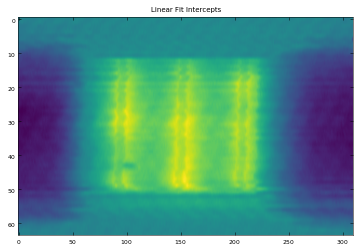

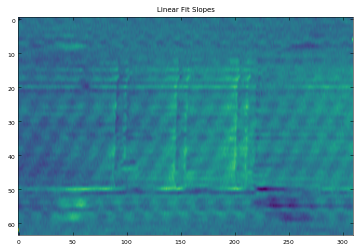

In [47]:
linearFitIntercepts = np.zeros(seqCube[0].shape)
linearFitSlopes = np.zeros(seqCube[0].shape)

for r in range(seqCube.shape[1]):
    for c in range(seqCube.shape[2]):
        ps = np.polyfit(list(range(len(seq))), seqCube[:,r,c], 1)
        linearFitSlopes[r,c] = ps[0]
        linearFitIntercepts[r,c] = ps[1]

plt.title('Linear Fit Intercepts')
plt.imshow(linearFitIntercepts, aspect='auto', interpolation='spline36')
plt.show()

plt.title('Linear Fit Slopes')
plt.imshow(linearFitSlopes, aspect='auto', interpolation='spline36')
plt.show()

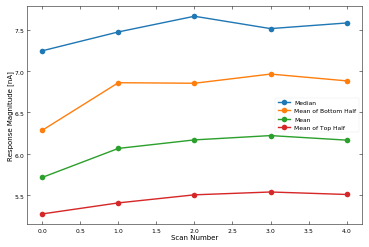

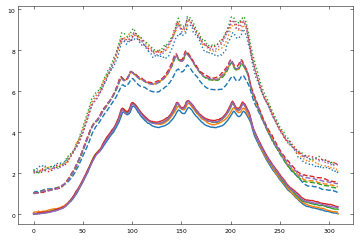

In [43]:
meanLines = []
meanLinesTop = []
meanLinesBot = []
medianLines = []

for cube in seqCube:
    meanLine = np.mean(cube,0)
    meanLine -= min(meanLine)
    meanLines.append(meanLine)
    
    meanLineTop = np.mean(cube[0:len(cube)//2],0)
    meanLineTop -= min(meanLineTop)
    meanLinesTop.append(meanLineTop)
    
    meanLineBot = np.mean(cube[len(cube)//2:],0)
    meanLineBot -= min(meanLineBot)
    meanLinesBot.append(meanLineBot)
    
    medianLine = np.median(cube,0)
    medianLine -= min(medianLine)
    medianLines.append(medianLine)

plt.plot([max(l) for l in medianLines], 'o-', label='Median')
plt.plot([max(l) for l in meanLinesBot], 'o-', label='Mean of Bottom Half')
plt.plot([max(l) for l in meanLines], 'o-', label='Mean')
plt.plot([max(l) for l in meanLinesTop], 'o-', label='Mean of Top Half')

plt.legend()
plt.xlabel('Scan Number')
plt.ylabel('Response Magnitude [nA]')
plt.show()

[plt.plot(l) for l in meanLinesTop]
plt.gca().set_prop_cycle(None)
[plt.plot(l+1, '--') for l in meanLinesBot]
plt.gca().set_prop_cycle(None)
[plt.plot(l+2, ':') for l in medianLines]
plt.show()

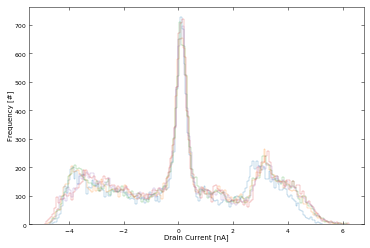

In [20]:
for i, cube in enumerate(seqCube):
    plt.hist(cube.flatten(), bins=150, histtype='step')

plt.xlabel('Drain Current [nA]')
plt.ylabel('Frequency [#]')
plt.show()

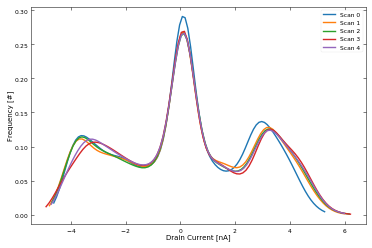

In [46]:
from scipy.stats import gaussian_kde

for i, cube in enumerate(seqCube):
    Is = np.linspace(np.min(cube), np.max(cube), 100)
    plt.plot(Is, gaussian_kde(cube.flatten())(Is), label='Scan {}'.format(i))

plt.legend()
plt.xlabel('Drain Current [nA]')
plt.ylabel('Frequency [#]')
plt.show()

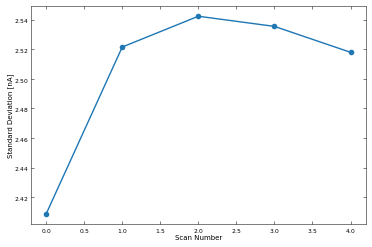

In [126]:
plt.plot(np.std(seqCube, axis=(1,2)), 'o-')

plt.xlabel('Scan Number')
plt.ylabel('Standard Deviation [nA]')
plt.show()

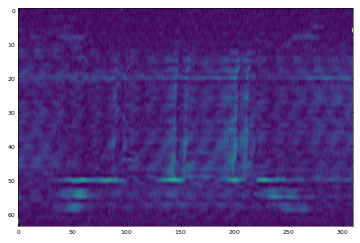

In [129]:
plt.imshow(np.std(seqCube, axis=0), aspect='auto', interpolation='spline36')
plt.show()

## Voltage Difference Dependence

In [16]:
experimentNumbers = list(range(26,36+1))

seq = []

for experimentNumber in experimentNumbers:
    try:
        e = {}

        dh = dlu.loadSpecificDeviceHistory('../../AutexysData/steven/SGM1/F1/E/E27N_10000_S4/', 'AFMControl.json', minExperiment=experimentNumber, maxExperiment=experimentNumber)
        
        traces = afm_ctrl.extractTraces(dh)
        traceNumber = 0

        Vx_vals = traces['Vx'][traceNumber]
        Vy_vals = traces['Vy'][traceNumber]
        Id_vals = traces['Id'][traceNumber]

        sgm_matrix, sgmWidth, sgmHeight = afm_ctrl.getRasteredMatrix(Vx_vals, Vy_vals, Id_vals)
        sgm_matrix = afm_ctrl.interpolate_nans(sgm_matrix)
        
        e['sgm_matrix'] = sgm_matrix*1e9
        e['sgmWidth'] = sgmWidth
        e['sgmHeight'] = sgmHeight
        e['runParams'] = dh[0]['runConfigs'][dh[0]['runType']]
        
        seq.append(e)
    except Exception as e:
        print('Error on Ex{}'.format(experimentNumber), e)
        for i, h in enumerate(dh):
            for key in h['Results'].keys():
                val = h['Results'][key]
                if isinstance(val, (list,)):
                    if len(val) != 350:
                        print('Line {} - {}: {}'.format(i, key, len(val)))

Unequal Lengths, altering data length by 1! Beware!
Unequal Lengths, altering data length by 1! Beware!
Unequal Lengths, altering data length by 1! Beware!
Unequal Lengths, altering data length by 1! Beware!
Unequal Lengths, altering data length by 1! Beware!
Unequal Lengths, altering data length by 1! Beware!


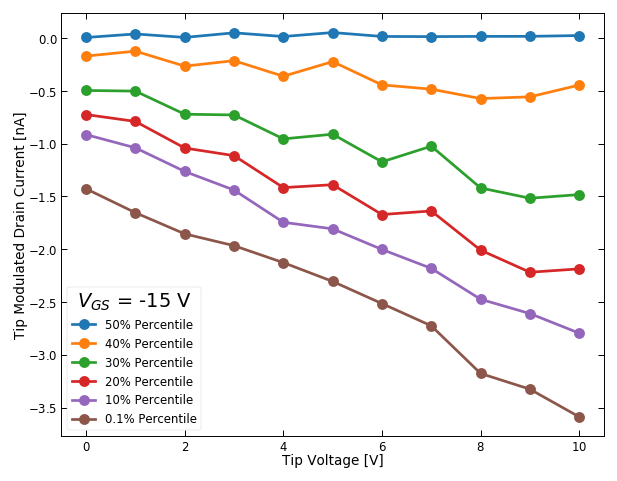

In [17]:
plt.figure(figsize=(5,4), dpi=140)

VTips = [e['runParams']['TipVoltage'] for e in seq]

for percentile in reversed([0.1, 10, 20, 30, 40, 50]):
    percentileIds = [np.percentile(e['sgm_matrix'], percentile) for e in seq]
    plt.plot(VTips, percentileIds, 'o-', label='{}% Percentile'.format(percentile))

plt.xlabel('Tip Voltage [V]')
plt.ylabel('Tip Modulated Drain Current [nA]')
plt.legend(title='$V_{GS}$ = -15 V')
plt.show()

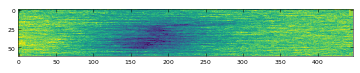

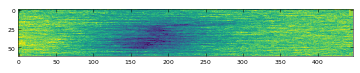

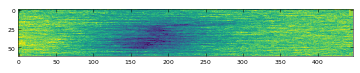

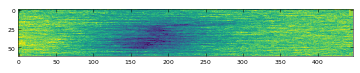

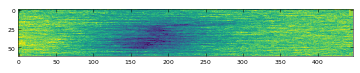

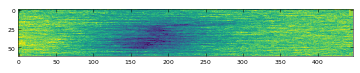

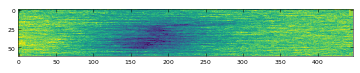

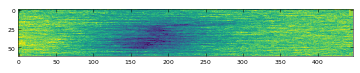

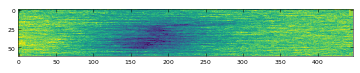

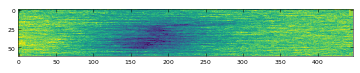

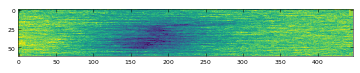

In [26]:
matrices = [e['sgm_matrix'] for e in seq]

alignedMatrices = alignMatrixes(matrices, masterIndex=1)
seqCube = makeDataCube(alignedMatrices)

for a in alignedMatrices:
    plt.imshow(am)
    plt.show()

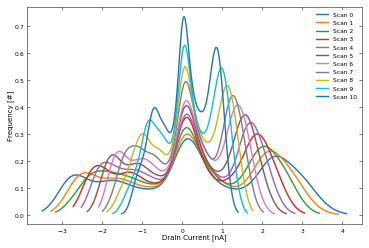

In [28]:
from scipy.stats import gaussian_kde

for i, cube in enumerate(seqCube):
    Is = np.linspace(np.min(cube), np.max(cube), 100)
    plt.plot(Is, gaussian_kde(cube.flatten())(Is), label='Scan {}'.format(i))

plt.legend()
plt.xlabel('Drain Current [nA]')
plt.ylabel('Frequency [#]')
plt.show()

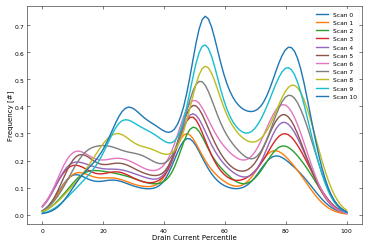

In [29]:
from scipy.stats import gaussian_kde

for i, cube in enumerate(seqCube):
    Is = np.linspace(np.min(cube), np.max(cube), 100)
    plt.plot(np.linspace(0,100,100), gaussian_kde(cube.flatten())(Is), label='Scan {}'.format(i))

plt.legend()
plt.xlabel('Drain Current Percentile')
plt.ylabel('Frequency [#]')
plt.show()

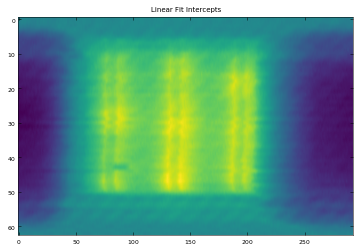

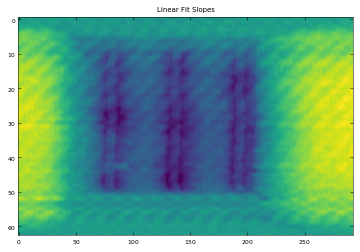

In [91]:
linearFitIntercepts = np.zeros(seqCube[0].shape)
linearFitSlopes = np.zeros(seqCube[0].shape)

for r in range(seqCube.shape[1]):
    for c in range(seqCube.shape[2]):
        ps = np.polyfit(list(range(len(seq))), seqCube[:,r,c], 1)
        linearFitSlopes[r,c] = ps[0]
        linearFitIntercepts[r,c] = ps[1]

plt.title('Linear Fit Intercepts')
plt.imshow(linearFitIntercepts, aspect='auto', interpolation='spline36')
plt.show()

plt.title('Linear Fit Slopes')
plt.imshow(linearFitSlopes, aspect='auto', interpolation='spline36')
plt.show()

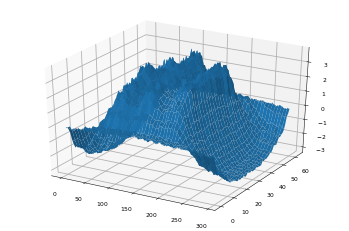

In [97]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.gca(projection='3d')

X, Y = np.meshgrid(list(range(linearFitIntercepts.shape[1])), list(range(linearFitIntercepts.shape[0])))

ax.plot_surface(X, Y, linearFitIntercepts)
plt.show()

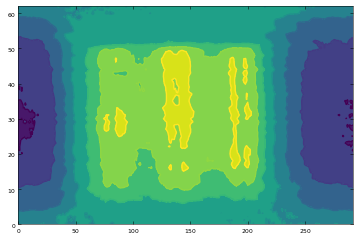

In [105]:
plt.contourf(linearFitIntercepts)
plt.contour(linearFitIntercepts)
plt.show()

No handles with labels found to put in legend.


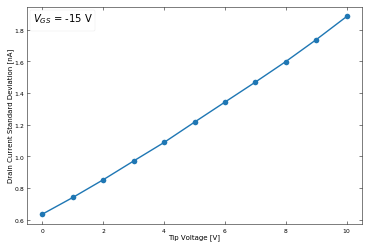

In [46]:
plt.plot(VTips, getFrameStandardDeviations(seqCube), 'o-')

plt.xlabel('Tip Voltage [V]')
plt.ylabel('Drain Current Standard Deviation [nA]')
plt.legend(title='$V_{GS}$ = -15 V')
plt.show()

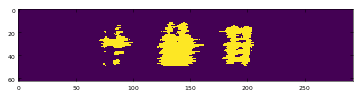

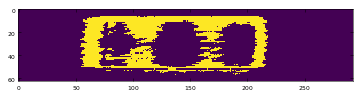

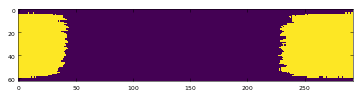

In [61]:
plt.imshow(getPercentileRangeMask(seqCube, 90, 100))
plt.show()

plt.imshow(getPercentileRangeMask(seqCube, 60, 80))
plt.show()

plt.imshow(getPercentileRangeMask(seqCube, 0, 30))
plt.show()

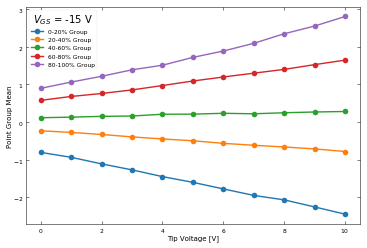

In [89]:
masks, pPairs = getMasksForPercentileGroups(seqCube)

for mask, pPair in zip(masks, pPairs):
    means = np.mean(seqCube[:,mask], axis=1)
    plt.plot(VTips, means, 'o-', label='{}-{}% Group'.format(pPair[0], pPair[1]))

plt.xlabel('Tip Voltage [V]')
plt.ylabel('Point Group Mean')
plt.legend(title='$V_{GS}$ = -15 V')
plt.show()

## Operating Point Dependence

In [4]:
experimentNumbers = list(range(36,46+1))

seq = []

for experimentNumber in experimentNumbers:
    try:
        e = {}

        dh = dlu.loadSpecificDeviceHistory('../../AutexysData/steven/SGM1/F1/E/E27N_10000_S4/', 'AFMControl.json', minExperiment=experimentNumber, maxExperiment=experimentNumber)
        
        traces = afm_ctrl.extractTraces(dh)
        traceNumber = 0
        
        Vx_vals = traces['Vx'][traceNumber]
        Vy_vals = traces['Vy'][traceNumber]
        Id_vals = traces['Id'][traceNumber]
        
        sgm_matrix, sgmWidth, sgmHeight = afm_ctrl.getRasteredMatrix(Vx_vals, Vy_vals, Id_vals)
        sgm_matrix = afm_ctrl.interpolate_nans(sgm_matrix)
        
        e['sgm_matrix'] = sgm_matrix*1e9
        e['sgmWidth'] = sgmWidth
        e['sgmHeight'] = sgmHeight
        e['runParams'] = dh[0]['runConfigs'][dh[0]['runType']]
        
        seq.append(e)
    except Exception as e:
        print('Error on Ex{}'.format(experimentNumber), e)

Unequal Lengths, altering data length by 1! Beware!


Unequal Lengths, altering data length by 1! Beware!


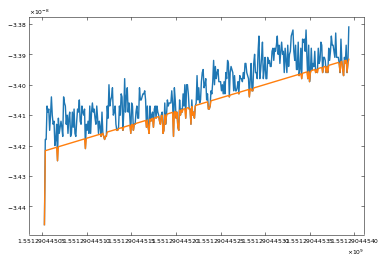

In [13]:
dh = dlu.loadSpecificDeviceHistory('../../AutexysData/steven/SGM1/F1/E/E27N_10000_S4/', 'AFMControl.json', minExperiment=experimentNumber, maxExperiment=experimentNumber)
traces = afm_ctrl.extractTraces(dh)

xs = traces['time'][0][0:1]
ys = traces['Id'][0][0:1]

baseline = calculateBaseline(xs, ys)

plt.plot(np.ravel(xs), np.ravel(ys))
plt.plot(np.ravel(xs), np.ravel(baseline))
plt.show()


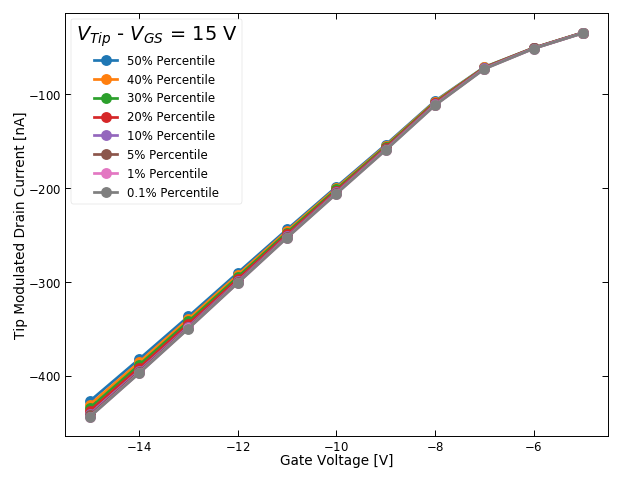

In [6]:
plt.figure(figsize=(5,4), dpi=140)

VTips = np.array([e['runParams']['TipVoltage'] for e in seq])
VGSs = np.array([e['runParams']['gateVoltageSetPoint'] for e in seq])

for percentile in reversed([0.1, 1, 5, 10, 20, 30, 40, 50]):
    percentileIds = [np.percentile(e['sgm_matrix'], percentile) for e in seq]
    plt.plot(VGSs, percentileIds, 'o-', label='{}% Percentile'.format(percentile))

plt.xlabel('Gate Voltage [V]')
plt.ylabel('Tip Modulated Drain Current [nA]')
plt.legend(title='$V_{Tip}$ - $V_{GS}$ = 15 V')
plt.show()

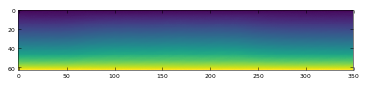

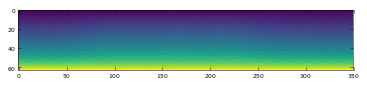

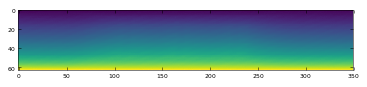

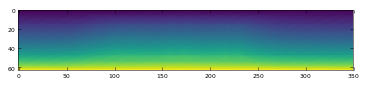

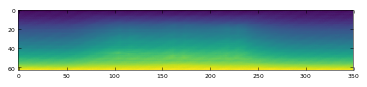

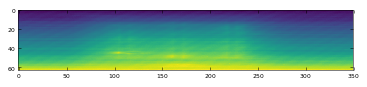

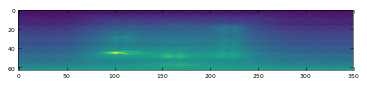

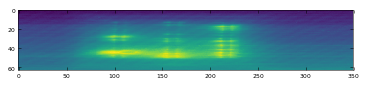

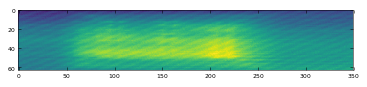

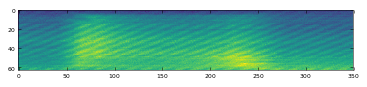

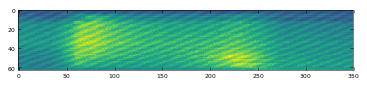

In [8]:
matrices = [e['sgm_matrix'] for e in seq]

alignedMatrices = alignMatrixes(matrices, masterIndex=1)
seqCube = makeDataCube(alignedMatrices)

for am in alignedMatrices:
    plt.imshow(am)
    plt.show()

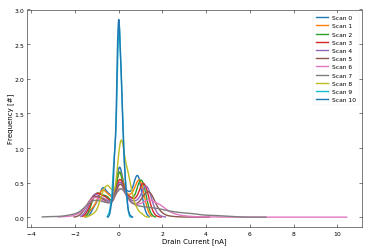

In [111]:
from scipy.stats import gaussian_kde

for i, cube in enumerate(seqCube):
    Is = np.linspace(np.min(cube), np.max(cube), 100)
    plt.plot(Is, gaussian_kde(cube.flatten())(Is), label='Scan {}'.format(i))

plt.legend()
plt.xlabel('Drain Current [nA]')
plt.ylabel('Frequency [#]')
plt.show()

No handles with labels found to put in legend.


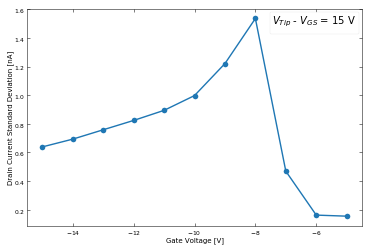

In [122]:
plt.plot(VGSs, getFrameStandardDeviations(seqCube), 'o-')

plt.xlabel('Gate Voltage [V]')
plt.ylabel('Drain Current Standard Deviation [nA]')
plt.legend(title='$V_{Tip}$ - $V_{GS}$ = 15 V')
plt.show()

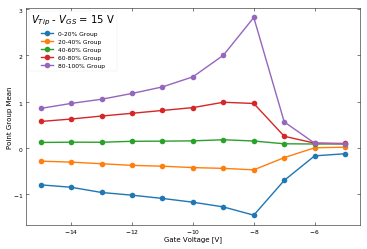

In [121]:
masks, pPairs = getMasksForPercentileGroups(seqCube)

for mask, pPair in zip(masks, pPairs):
    means = np.mean(seqCube[:,mask], axis=1)
    plt.plot(VGSs, means, 'o-', label='{}-{}% Group'.format(pPair[0], pPair[1]))

plt.xlabel('Gate Voltage [V]')
plt.ylabel('Point Group Mean')
plt.legend(title='$V_{Tip}$ - $V_{GS}$ = 15 V')
plt.show()

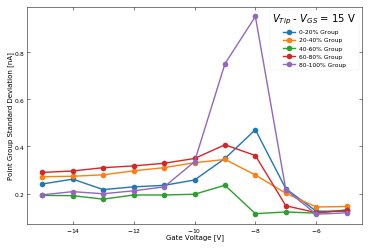

In [120]:
masks, pPairs = getMasksForPercentileGroups(seqCube)

for mask, pPair in zip(masks, pPairs):
    vals = np.std(seqCube[:,mask], axis=1)
    plt.plot(VGSs, vals, 'o-', label='{}-{}% Group'.format(pPair[0], pPair[1]))

plt.xlabel('Gate Voltage [V]')
plt.ylabel('Point Group Standard Deviation [nA]')
plt.legend(title='$V_{Tip}$ - $V_{GS}$ = 15 V')
plt.show()

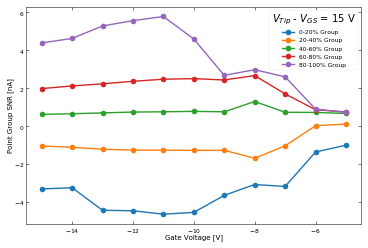

In [119]:
masks, pPairs = getMasksForPercentileGroups(seqCube)

for mask, pPair in zip(masks, pPairs):
    stds = np.std(seqCube[:,mask], axis=1)
    means = np.mean(seqCube[:,mask], axis=1)
    vals = means/stds
    plt.plot(VGSs, vals, 'o-', label='{}-{}% Group'.format(pPair[0], pPair[1]))

plt.xlabel('Gate Voltage [V]')
plt.ylabel('Point Group SNR [nA]')
plt.legend(title='$V_{Tip}$ - $V_{GS}$ = 15 V')
plt.show()

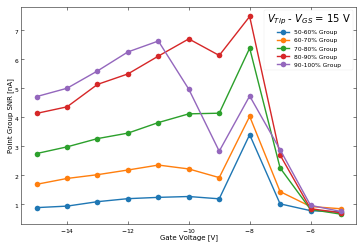

In [133]:
masks, pPairs = getMasksForPercentileGroups(seqCube, percentileBreaks=[50,60,70,80,90,100])

for mask, pPair in zip(masks, pPairs):
    stds = np.std(seqCube[:,mask], axis=1)
    means = np.mean(seqCube[:,mask], axis=1)
    vals = means/stds
    plt.plot(VGSs, vals, 'o-', label='{}-{}% Group'.format(pPair[0], pPair[1]))

plt.xlabel('Gate Voltage [V]')
plt.ylabel('Point Group SNR [nA]')
plt.legend(title='$V_{Tip}$ - $V_{GS}$ = 15 V')
plt.show()

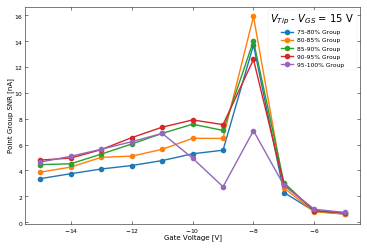

In [134]:
masks, pPairs = getMasksForPercentileGroups(seqCube, percentileBreaks=[75,80,85,90,95,100])

for mask, pPair in zip(masks, pPairs):
    stds = np.std(seqCube[:,mask], axis=1)
    means = np.mean(seqCube[:,mask], axis=1)
    vals = means/stds
    plt.plot(VGSs, vals, 'o-', label='{}-{}% Group'.format(pPair[0], pPair[1]))

plt.xlabel('Gate Voltage [V]')
plt.ylabel('Point Group SNR [nA]')
plt.legend(title='$V_{Tip}$ - $V_{GS}$ = 15 V')
plt.show()

In [ ]:
%lprun -f get_farthest get_farthest(trace, origin)

Steven mean is 99.2, median is 99.1, std is 0.4
Edison mean is 99.9, median is 100.0, std is 0.4
Edison2 mean is 101.2, median is 101.4, std is 0.5


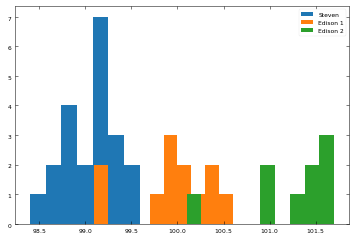

In [146]:
edison = [99.9,99.1,100.6,99.9,100.1,99.8,100.4,100.1,100.3,99.9,100.2,99.1]
steven = [99.5, 98.4,100.1,99.1,100.0,99.8,98.9,99.0,99.5,99.3,99.0,99.1,99.3,98.6,99.2,99.1,98.9,99.1,98.8,99.1,98.7,99.2,99.4,98.9]
edison2 = [101, 101.6, 101.7,101.5,101,101.6,101.3,101.4,100.1]

print('Steven mean is {:.1f}, median is {:.1f}, std is {:.1f}'.format(np.mean(steven), np.median(steven), np.std(steven)))
print('Edison mean is {:.1f}, median is {:.1f}, std is {:.1f}'.format(np.mean(edison), np.median(edison), np.std(edison)))
print('Edison2 mean is {:.1f}, median is {:.1f}, std is {:.1f}'.format(np.mean(edison2), np.median(edison2), np.std(edison2)))

plt.hist(steven, label='Steven')
plt.hist(edison, label='Edison 1')
plt.hist(edison2, label='Edison 2')
plt.legend()
plt.show()

In [ ]:
stevenslow = [97.1, 97.5]
edisonslow = [97.7]